In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from scipy.stats import pointbiserialr, chi2_contingency

In [31]:
train_df = pd.read_csv("data/train.csv", index_col="id")
test_df = pd.read_csv("data/test.csv", index_col="id")

train_extra = pd.read_csv("data/training_extra.csv", index_col="id")

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 290295 non-null  object 
 1   Material              291653 non-null  object 
 2   Size                  293405 non-null  object 
 3   Compartments          300000 non-null  float64
 4   Laptop Compartment    292556 non-null  object 
 5   Waterproof            292950 non-null  object 
 6   Style                 292030 non-null  object 
 7   Color                 290050 non-null  object 
 8   Weight Capacity (kg)  299862 non-null  float64
 9   Price                 300000 non-null  float64
dtypes: float64(3), object(7)
memory usage: 25.2+ MB


In [33]:
train_df.describe()

,Compartments,Weight Capacity (kg),Price
count,300000.000000,299862.000000,300000.000000
mean,5.443590,18.029994,81.411107
std,2.890766,6.966914,39.039340
min,1.000000,5.000000,15.000000
25%,3.000000,12.097867,47.384620
50%,5.000000,18.068614,80.956120
75%,8.000000,24.002375,115.018160
max,10.000000,30.000000,150.000000


In [34]:
train_df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [35]:
train_df[train_df.isna().any(axis=1)]

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
5,Nike,Canvas,Medium,10.0,No,Yes,NaN,Black,7.241812,20.01553
6,Nike,NaN,Large,3.0,No,No,Backpack,Green,6.828123,84.80500
10,Nike,Polyester,Large,1.0,Yes,No,Backpack,NaN,27.806951,68.31047
11,Nike,Polyester,NaN,10.0,No,No,NaN,Gray,13.697554,23.25963
21,Under Armour,Polyester,NaN,9.0,Yes,Yes,Messenger,Gray,11.219052,35.46348
...,...,...,...,...,...,...,...,...,...,...
299975,Jansport,Leather,Medium,8.0,No,Yes,Messenger,NaN,20.355501,110.42196
299978,NaN,Canvas,Large,6.0,Yes,No,Tote,Gray,5.000000,50.78781
299983,Puma,Nylon,Large,9.0,Yes,Yes,NaN,Black,25.499734,54.18523


In [36]:
def convert_cols(df, cat_feats):
    # df["Compartments"] = df["Compartments"].astype(pd.Int8Dtype())
    # df["Weight Capacity (kg)"] = df["Weight Capacity (kg)"].astype(pd.Float32Dtype())

    for feat in cat_feats:
        df[feat] = df[feat].astype("category")


    return df

CONT_FEATS = ["Compartments", "Weight Capacity (kg)"]
CAT_FEATS = [name for name in train_df.columns.to_list() if name not in CONT_FEATS and name != "Price"]
TARGET_FEAT = "Price"

train_df = convert_cols(train_df, CAT_FEATS)


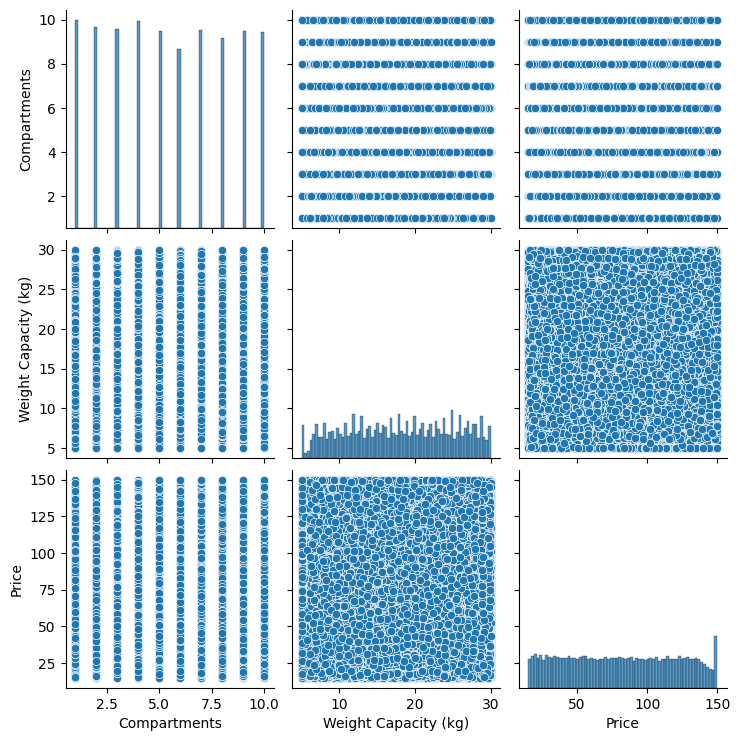

In [37]:
sns.pairplot(train_df)

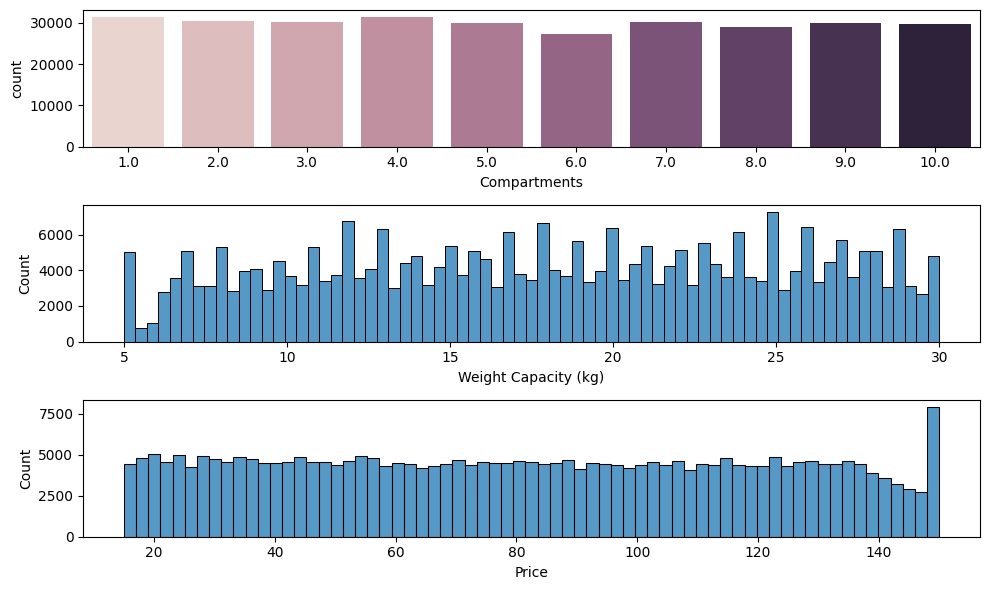

In [38]:
fig, ax = plt.subplots(3, 1, figsize=(10,6))
ax = ax.flatten()

# for i, feat in enumerate(tqdm(CONT_FEATS + ["Price"])):
#     sns.kdeplot(data=train_df, x=feat, ax=ax[i])

sns.countplot(data=train_df, x="Compartments", hue="Compartments", ax=ax[0], legend=False)
sns.histplot(data=train_df, x="Weight Capacity (kg)", ax=ax[1])
sns.histplot(data=train_df, x="Price", ax=ax[2])

plt.tight_layout()
plt.show()

100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


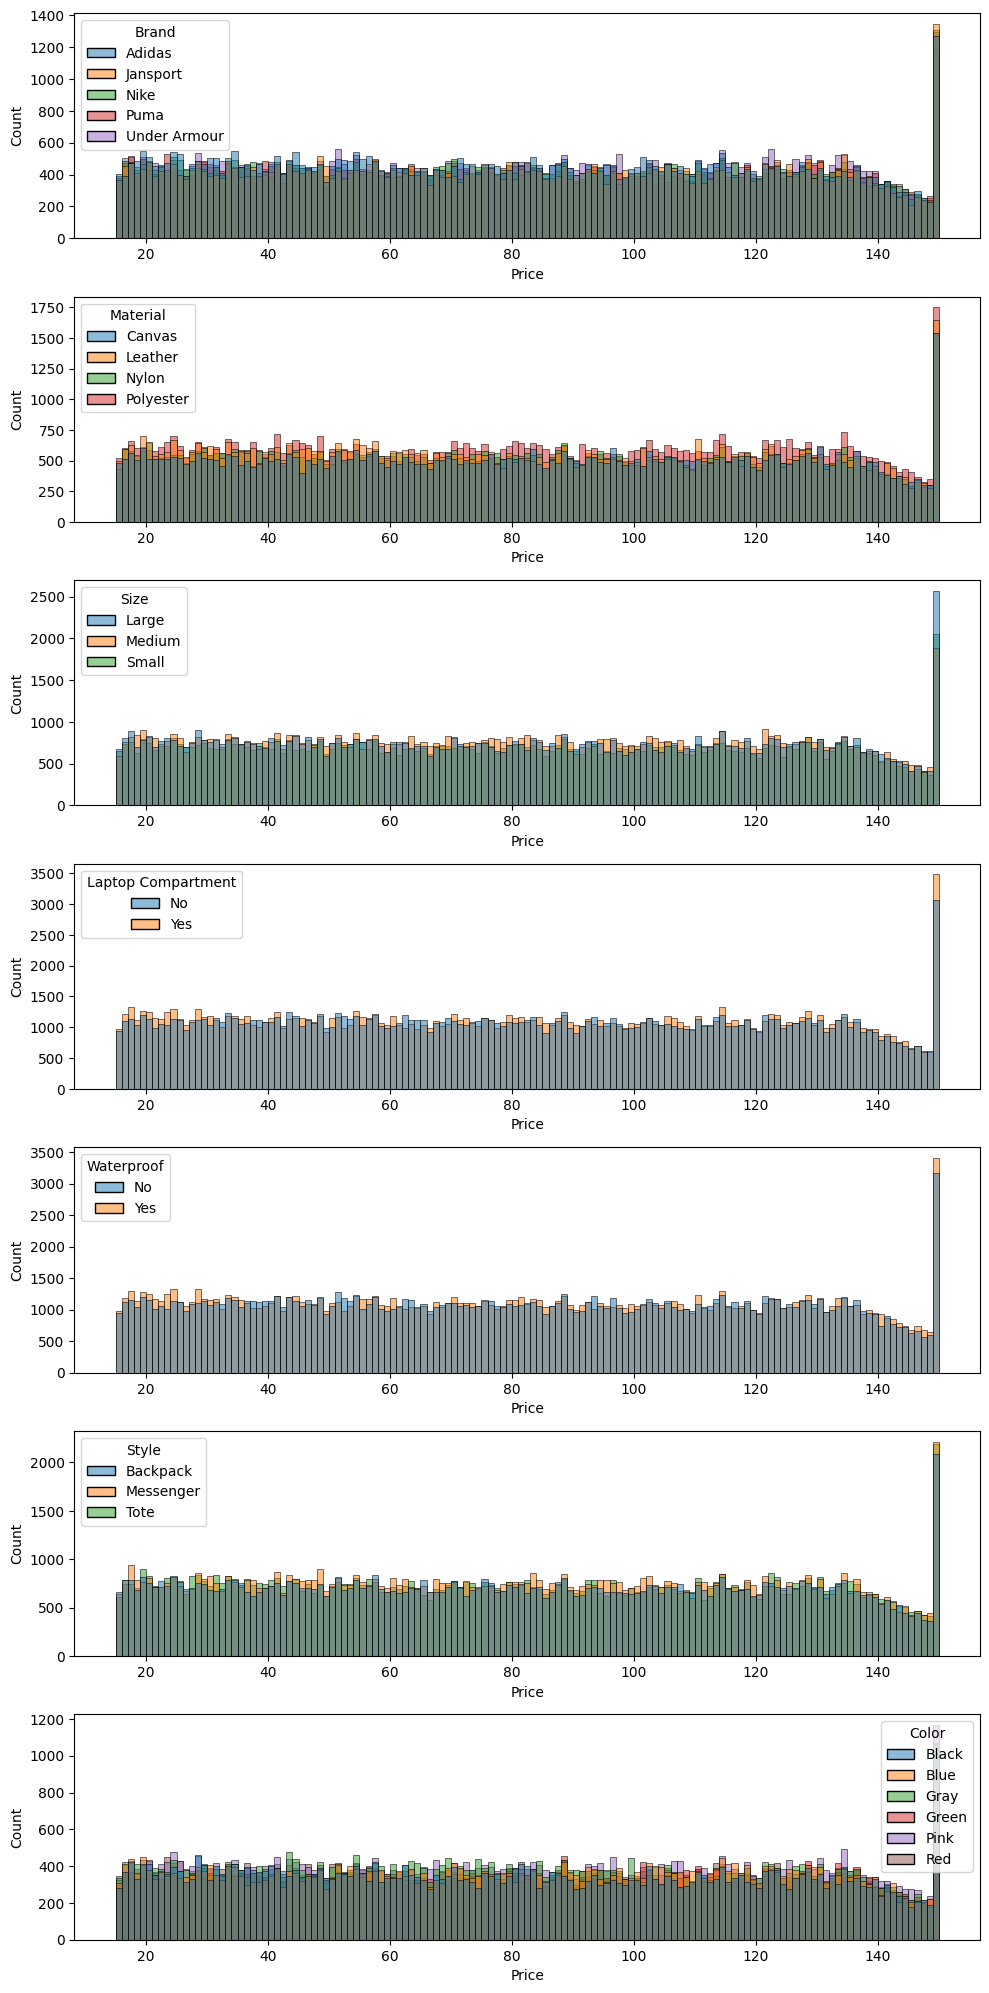

In [53]:
fig, ax = plt.subplots(7, 1, figsize=(10,20))
ax = ax.flatten()

for i, feat in enumerate(tqdm(CAT_FEATS)):
    # sns.histplot(data=train_df, x="Price", kde=True, hue=feat, ax=ax[i], legend=False, multiple="dodge")
    sns.histplot(data=train_df, x="Price", hue=feat, ax=ax[i], binwidth=1)

plt.tight_layout()
plt.show()

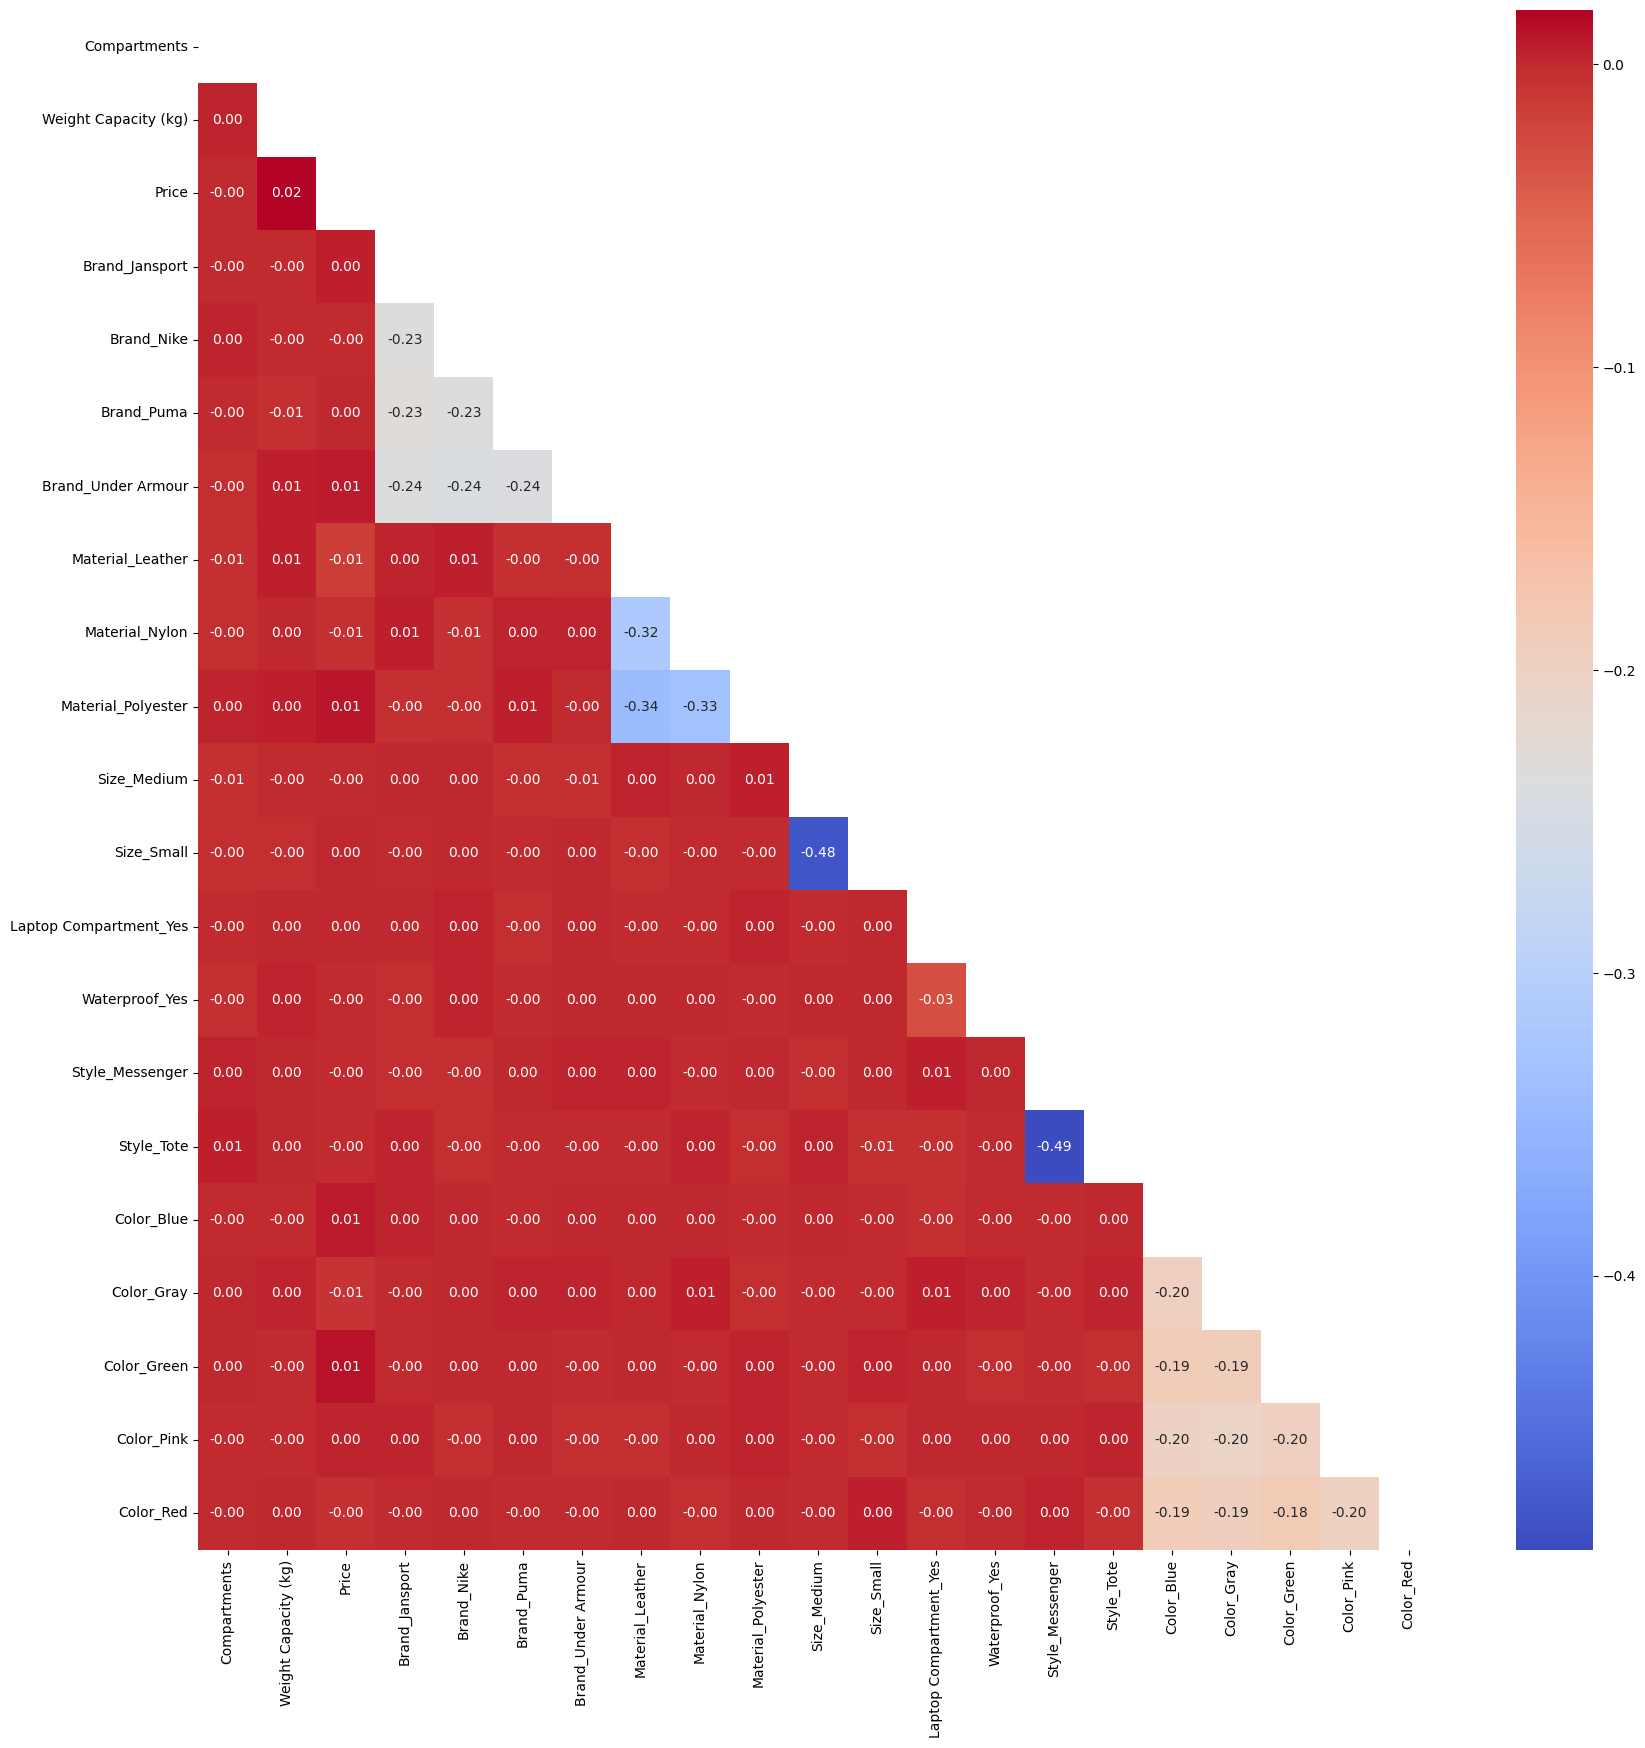

In [42]:
corr_df = train_df
corr_df = pd.get_dummies(corr_df, drop_first=True)
# for feat in CAT_FEATS:   
#     corr_df[feat] = corr_df[feat].cat.rename_categories({cat:i for i, cat in enumerate(corr_df[feat].cat.categories.to_list())})

corr = corr_df.corr()
mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.show()

In [45]:
null_df = train_df[train_df.isnull().any(axis=1)]
non_null_df = train_df[train_df.notnull().all(axis=1)]

In [48]:
print(null_df.info())
print()
print(non_null_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 53314 entries, 5 to 299991
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Brand                 43609 non-null  category
 1   Material              44967 non-null  category
 2   Size                  46719 non-null  category
 3   Compartments          53314 non-null  float64 
 4   Laptop Compartment    45870 non-null  category
 5   Waterproof            46264 non-null  category
 6   Style                 45344 non-null  category
 7   Color                 43364 non-null  category
 8   Weight Capacity (kg)  53176 non-null  float64 
 9   Price                 53314 non-null  float64 
dtypes: category(7), float64(3)
memory usage: 2.0 MB
None

<class 'pandas.core.frame.DataFrame'>
Index: 246686 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   


In [49]:
null_counts = null_df.isnull().sum(axis=1)
null_df.loc[null_counts.sort_values(ascending=False).index]

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
12701,Jansport,NaN,NaN,7.0,NaN,Yes,Messenger,NaN,15.895100,149.81684
194866,NaN,Leather,NaN,7.0,NaN,NaN,Messenger,Black,16.665780,148.71836
236227,Nike,Polyester,Large,9.0,Yes,NaN,NaN,NaN,NaN,18.63272
41606,NaN,Nylon,Medium,2.0,NaN,NaN,Tote,Pink,NaN,115.29373
96754,Puma,NaN,Medium,9.0,NaN,Yes,NaN,NaN,28.294500,126.36766
...,...,...,...,...,...,...,...,...,...,...
102795,Adidas,Nylon,Large,7.0,Yes,Yes,NaN,Green,28.651928,108.10023
102803,NaN,Polyester,Small,3.0,No,Yes,Tote,Pink,21.868805,43.90269
102806,Under Armour,Canvas,Medium,2.0,NaN,No,Tote,Blue,20.094425,26.29994


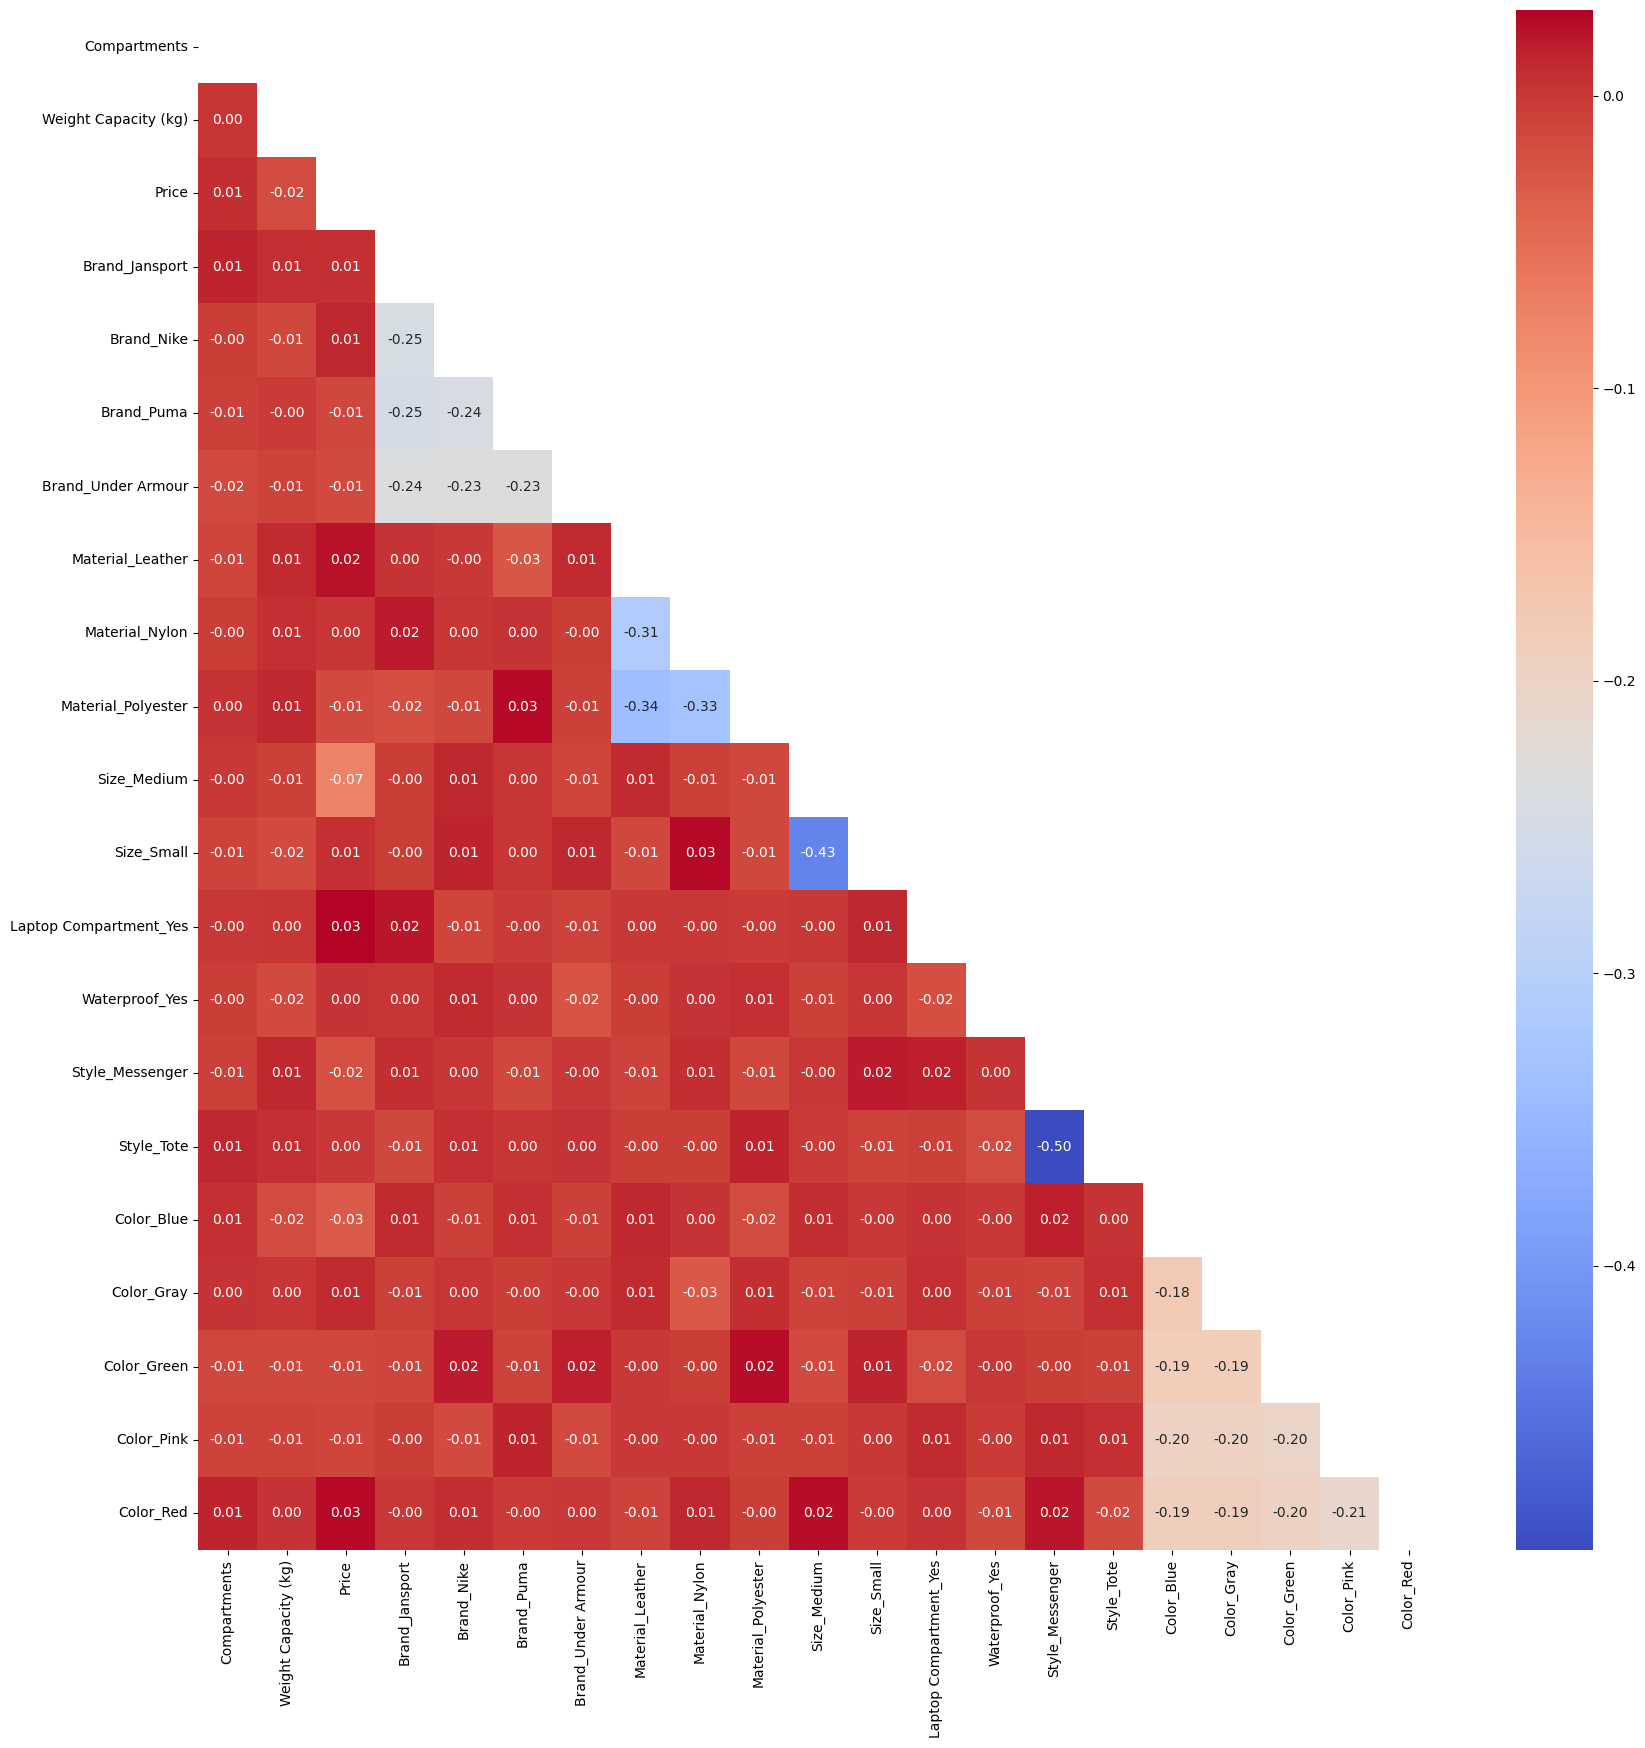

In [56]:
max_price_corr_df = corr_df[corr_df["Price"] > 148]

corr = max_price_corr_df.corr()
mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.show()